In [1]:
import sys
sys.path.append('../libs')  # Update this path according to the location of your 'dataset' module
sys.path.append('../Files') 

import os
import classes

import numpy as np

import torch

from classifier_architectures import AudioClassifierCNN

In [2]:
# Function to get all file paths with a specific extension in a directory
def get_file_paths(directory, extension=".npy"):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(extension)]

In [3]:
# Directory containing the new .npy files
new_data_directory = '../Files/scence_analysis'
new_file_paths = get_file_paths(new_data_directory)
print("Collected new file paths:", new_file_paths)

Collected new file paths: ['../Files/scence_analysis\\2_Florian_Heizung_aus.npy', '../Files/scence_analysis\\3_Verena_Staubsauger_an_Alarm_an.npy', '../Files/scence_analysis\\5_Lukas_Staubsauger_an_Licht_aus.npy', '../Files/scence_analysis\\6_Deepak_Radio_aus_Licht_aus.npy']


In [4]:
dataset_audio = np.load(new_file_paths[0])[:, 12:76, :]

In [5]:
dataset_audio.shape

(1, 64, 854)

In [6]:
dataset_audio_tensor = torch.tensor(dataset_audio, dtype=torch.float32)

In [7]:
## import numpy as np
import matplotlib.pyplot as plt
from classifier_architectures import AudioClassifierCNN

import torch

def sliding_window_prediction(model, input_data, window_size, stride, threshold):
    """
    Perform sliding window prediction using a given model.

    Parameters:
    - model: The CNN classifier model.
    - input_data: The longer frame input data (shape: 1*64*854).
    - window_size: The size of the sliding window (number of timesteps).
    - stride: The stride of the sliding window.
    - threshold: The threshold for predicted probabilities.

    Returns:
    - all_predictions: A list of predicted probabilities for all windows and classes.
    - threshold_predictions: A list of tuples (start, end, prediction_tensor) for windows where the maximum predicted probability exceeds the threshold.
    """

    # Calculate the number of windows
    num_windows = ((input_data.shape[2] - window_size) // stride) + 1

    # Initialize empty lists to store predictions
    all_predictions = []
    threshold_predictions = []

    # Slide the window over the input data and make predictions
    for i in range(num_windows):
        # Extract the current window
        start = i * stride
        end = start + window_size
        window_data = input_data[:, :, start:end]
        
        # Make prediction using the model
        y_logit = model(window_data)
        
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1)
        
        # Store the predicted probability tensor in all_predictions
        all_predictions.append(y_pred.cpu())
        
        # Check if the maximum predicted probability is above the threshold
        if torch.max(y_pred) >= threshold:
            # Store the predicted probability tensor along with start and end indices
            threshold_predictions.append((start, end, torch.argmax(y_pred)))
    
    return all_predictions, threshold_predictions


In [8]:
# Define the file path
file_path = r"saved_models\model_lr_0.001.pth"

# Load the model
model = AudioClassifierCNN(len(classes.CLASSES))
model.load_state_dict(torch.load(file_path))

# Set the model to evaluation mode
model.eval()

AudioClassifierCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=11, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=0)
)

In [9]:
all_predictions, threshold_predictions = sliding_window_prediction(model, dataset_audio_tensor, window_size=44, stride=11, threshold=0.7)

In [10]:
def display_predictions(all_predictions):
    # Iterate over each tensor in all_predictions
    for i, pred_tensor in enumerate(all_predictions):
        # Convert the tensor to a numpy array
        pred_array = pred_tensor.detach().numpy()
        
        # Print the predictions for the current window
        print(f"Window {i+1}:")
        for class_index, class_pred in enumerate(pred_array[0]):
            print(f"Class {class_index}: {class_pred:.4f}")
        print()

In [11]:
# display_predictions(all_predictions)

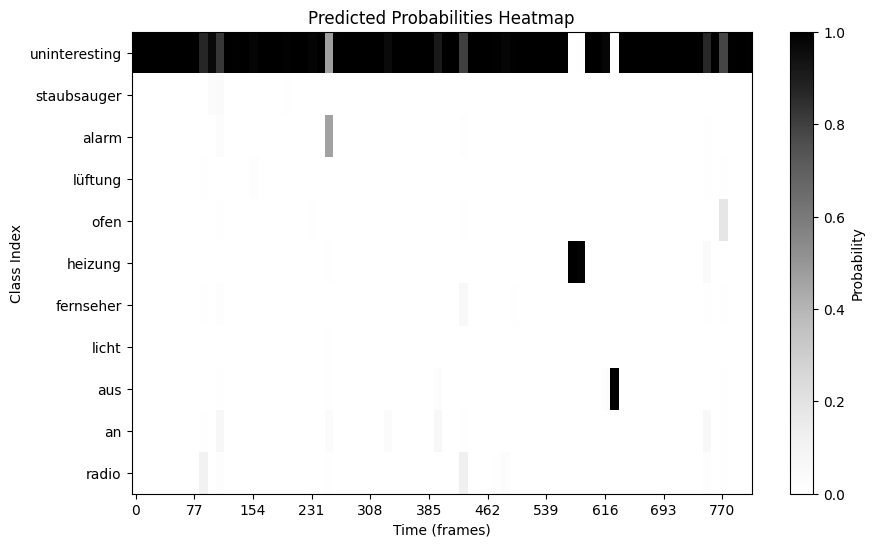

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def display_predictions_heatmap_with_timestamps(all_predictions, classes_dict, window_size, stride, num_displayed_timestamps=10):
    # Convert the list of tensors into a numpy array
    all_predictions_array = np.array([pred.detach().numpy() for pred in all_predictions])
    
    # Calculate timestamps for each window
    num_windows = len(all_predictions)
    timestamps = [(i * stride, i * stride + window_size) for i in range(num_windows)]

    # Determine the step for displaying timestamps
    step = max(num_windows // num_displayed_timestamps, 1)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(all_predictions_array.squeeze().T, cmap='Greys', interpolation='nearest', aspect='auto', vmin=0, vmax=1)
    plt.colorbar(label='Probability')
    plt.xlabel('Time (frames)')
    plt.ylabel('Class Index')
    plt.title('Predicted Probabilities Heatmap')
    
    # Set x-axis labels as timestamps
    plt.xticks(ticks=np.arange(0, num_windows, step), labels=np.arange(0, num_windows * stride, step * stride))
    
    # Set y-axis labels as class indices
    if classes_dict:
        plt.yticks(ticks=np.arange(len(classes_dict)), labels=list(classes_dict.keys()))
    
    plt.show()

# Example usage:
# Assuming all_predictions is the returned value from the sliding_window_prediction function
# Assuming classes_dict is a dictionary mapping class indices to class labels
# Assuming window_size and stride are provided
display_predictions_heatmap_with_timestamps(all_predictions, classes.CLASSES, window_size=44, stride=11)


In [13]:
threshold_predictions

[(0, 44, tensor(0)),
 (11, 55, tensor(0)),
 (22, 66, tensor(0)),
 (33, 77, tensor(0)),
 (44, 88, tensor(0)),
 (55, 99, tensor(0)),
 (66, 110, tensor(0)),
 (77, 121, tensor(0)),
 (88, 132, tensor(0)),
 (99, 143, tensor(0)),
 (110, 154, tensor(0)),
 (121, 165, tensor(0)),
 (132, 176, tensor(0)),
 (143, 187, tensor(0)),
 (154, 198, tensor(0)),
 (165, 209, tensor(0)),
 (176, 220, tensor(0)),
 (187, 231, tensor(0)),
 (198, 242, tensor(0)),
 (209, 253, tensor(0)),
 (220, 264, tensor(0)),
 (231, 275, tensor(0)),
 (242, 286, tensor(0)),
 (264, 308, tensor(0)),
 (275, 319, tensor(0)),
 (286, 330, tensor(0)),
 (297, 341, tensor(0)),
 (308, 352, tensor(0)),
 (319, 363, tensor(0)),
 (330, 374, tensor(0)),
 (341, 385, tensor(0)),
 (352, 396, tensor(0)),
 (363, 407, tensor(0)),
 (374, 418, tensor(0)),
 (385, 429, tensor(0)),
 (396, 440, tensor(0)),
 (407, 451, tensor(0)),
 (418, 462, tensor(0)),
 (429, 473, tensor(0)),
 (440, 484, tensor(0)),
 (451, 495, tensor(0)),
 (462, 506, tensor(0)),
 (473, 51

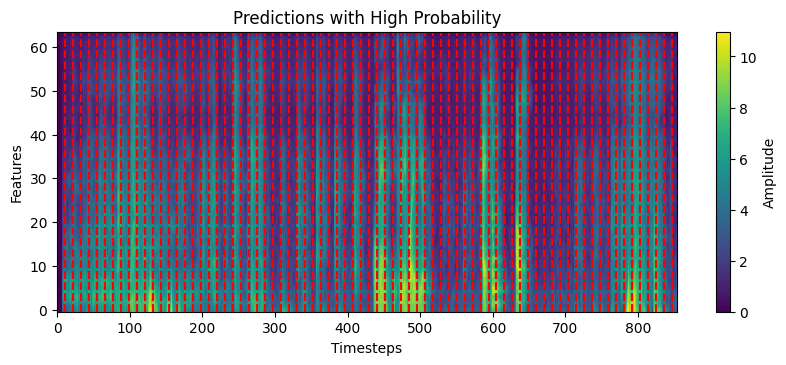

In [15]:
def plot_predictions_heatmap(predictions, input_data, class_labels):
    plt.figure(figsize=(10, 8))
    
    # Plot the original input data
    plt.subplot(2, 1, 1)
    plt.imshow(input_data.squeeze(0), aspect='auto', origin='lower', cmap='viridis')
    for prediction in predictions:
        start, end, _ = prediction
        plt.axvline(x=start, color='r', linestyle='--')
        plt.axvline(x=end, color='r', linestyle='--')
    plt.xlabel('Timesteps')
    plt.ylabel('Features')
    plt.title('Predictions with High Probability')
    plt.colorbar(label='Amplitude')
    plt.show()

# Example usage:
plot_predictions_heatmap(threshold_predictions, dataset_audio_tensor, classes.CLASSES)